# NIHCXR Clinical Drift Experiments Tutorial

## Import Libraries and Load NIHCXR Dataset

In [1]:
from functools import partial

from monai.transforms import AddChanneld, Compose, Lambdad, Resized, ToDeviced
from torchxrayvision.models import DenseNet

from cyclops.data.loader import load_nihcxr
from cyclops.data.slicer import SliceSpec
from cyclops.data.utils import apply_transforms
from cyclops.monitor import ClinicalShiftApplicator, Detector, Reductor, TSTester
from cyclops.monitor.plotter import plot_drift_experiment, plot_drift_timeseries
from cyclops.monitor.utils import get_device

device = get_device()

nih_ds = load_nihcxr("/mnt/data/clinical_datasets/NIHCXR")

/home/amritk/.cache/pypoetry/virtualenvs/pycyclops-wIzUAwxh-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Example 1. Generate Source/Target Dataset for Experiments (1-2)

In [2]:
shifter = ClinicalShiftApplicator(
    "sex", source=None, target="F", shift_id="Patient Gender"
)
source_ds, target_ds = shifter.apply_shift(nih_ds, num_proc=6)

transforms = Compose(
    [
        AddChanneld(keys=("features",), allow_missing_keys=True),
        Resized(
            keys=("features",), spatial_size=(1, 224, 224), allow_missing_keys=True
        ),
        Lambdad(
            keys=("features",),
            func=lambda x: ((2 * (x / 255.0)) - 1.0) * 1024,
            allow_missing_keys=True,
        ),
        ToDeviced(keys=("features",), device=device, allow_missing_keys=True),
    ]
)

source_ds = source_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)
target_ds = target_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 70533.20 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 98620.42 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 118317.81 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 130355.23 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 138838.65 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 147719.46 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 74303.13 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 108273.47 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 127844.63 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 133155.82 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 154587.54 examples/s]

## Example 2. Sensitivity test experiment with 3 dimensionality reduction techniques


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:02<00:10, 15.78 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 28.41 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 38.30 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.68 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 51.63 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 54.66 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 54.43 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.00 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.53 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.75 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.63 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.57 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.21 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.58 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.15 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.50 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 48.88 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.02 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.73 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:10, 16.30 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 27.92 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 35.87 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 42.45 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 46.80 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 49.81 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 49.28 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.20 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.49 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.06 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 28.43 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 35.42 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:02<00:10, 15.62 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:05, 26.54 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:03, 33.94 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 38.36 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 42.37 examples/s]

Map:  96%|█████████▌| 192/200 [00:05<00:00, 44.74 examples/s]

Map: 100%|██████████| 200/200 [00:05<00:00, 44.34 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.96 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.12 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.89 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.28 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 51.12 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 54.03 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 54.29 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.67 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.53 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.95 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.94 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.32 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.78 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.54 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 37.68 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 43.47 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 46.86 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 49.03 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 49.36 examples/s]

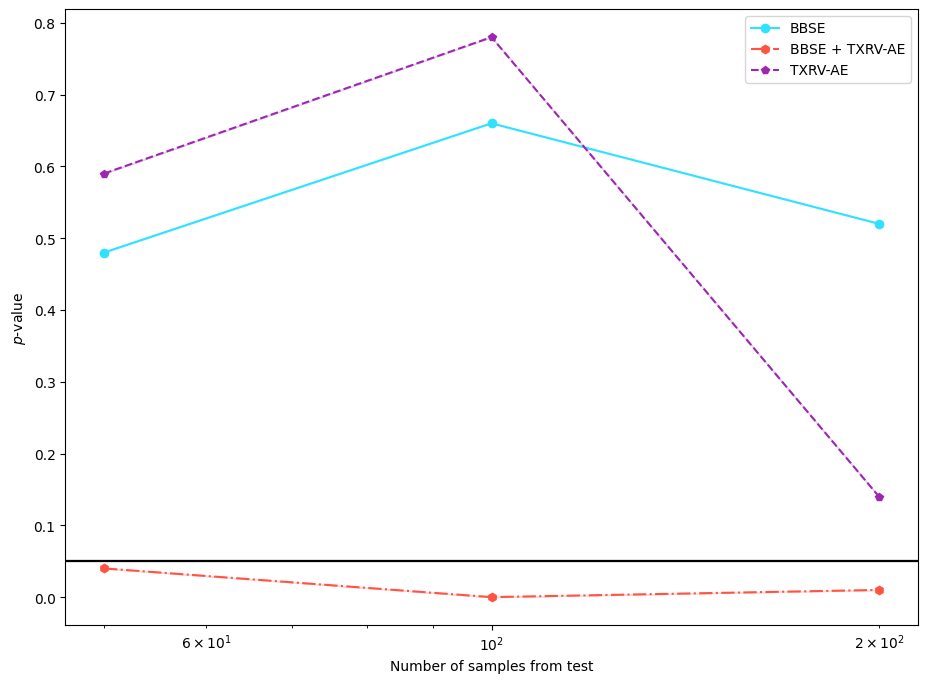

In [3]:
model = DenseNet(weights="densenet121-res224-all")
dr_methods = {
    "BBSE": "bbse-soft",
    "BBSE + TXRV-AE": "bbse-soft+txrv-ae",
    "TXRV-AE": "txrv-ae",
}
results = {}

for name, dr_method in dr_methods.items():
    if name == "TXRV-AE":
        reductor = Reductor(dr_method=dr_method, device=device)
    else:
        reductor = Reductor(dr_method=dr_method, model=model, device=device)
    detector = Detector(
        "sensitivity_test",
        reductor=reductor,
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    result = detector.detect_shift(source_ds, target_ds)
    results[name] = result
plot_drift_experiment(results)

## Example 3. Sensitivity test experiment with models trained on different datasets

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.12 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.85 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.27 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.37 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 52.99 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 55.47 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.14 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.75 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.52 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.45 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.26 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 37.75 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.72 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.37 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.24 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.53 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.35 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.23 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.71 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.08 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.37 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.28 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 47.40 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 52.90 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.21 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.85 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.77 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.62 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.84 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.53 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.32 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.18 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.79 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.03 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.19 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.92 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.58 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.37 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.47 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.60 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.36 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 47.85 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.12 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 55.87 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.67 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.39 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.28 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.81 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.77 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.26 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.65 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.01 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.82 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.90 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.05 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 51.52 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.25 examples/s]

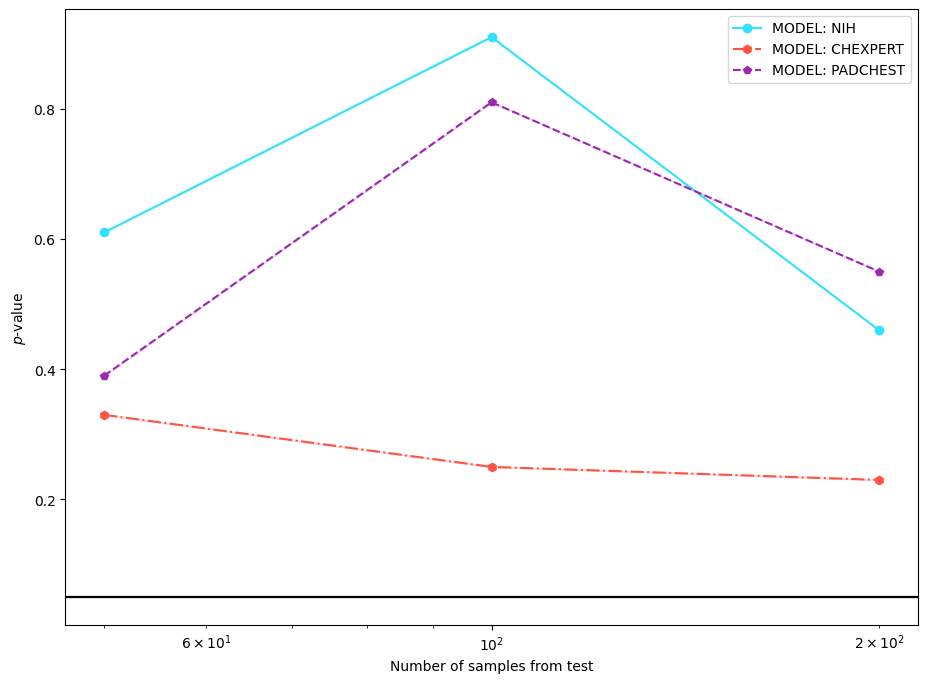

In [4]:
models = {
    "MODEL: NIH": "densenet121-res224-nih",
    "MODEL: CHEXPERT": "densenet121-res224-chex",
    "MODEL: PADCHEST": "densenet121-res224-pc",
}
results = {}

for model_name, model in models.items():
    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(
            dr_method="bbse-soft", model=DenseNet(weights=model), device=device
        ),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    results[model_name] = detector.detect_shift(source_ds, target_ds)
plot_drift_experiment(results)

## Example 4. Sensitivity test experiment with different clinical shifts

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 56375.61 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 80381.53 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 92826.23 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 97220.12 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 101841.93 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 108586.37 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 54123.10 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 77146.53 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 89325.33 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 96099.40 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 101144.79 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 104702.88 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.34 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.94 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.36 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.38 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.71 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 55.38 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 54.88 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.37 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.15 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.62 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.04 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.23 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.00 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.69 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.77 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.75 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.18 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.66 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.19 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 53374.83 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 76290.44 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 88849.79 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 95556.17 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 100472.11 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 101069.40 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 52181.22 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 74266.10 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 86822.93 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 90334.91 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 99673.72 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 103011.37 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.25 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.96 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.82 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.81 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 52.92 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.87 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.55 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.05 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.99 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.79 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.60 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.32 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.55 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.11 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.27 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.39 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.85 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.17 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.75 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 55168.94 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 77663.33 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 89271.92 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 96779.55 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 100928.15 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 103883.16 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 47701.53 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 68091.69 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 76854.85 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 85273.68 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 89644.26 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 100131.37 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.22 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.71 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.33 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.84 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.66 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.49 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.21 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.02 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.42 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.09 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.78 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.08 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.92 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.64 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.22 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.40 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.95 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.72 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.10 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 52134.95 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 71911.10 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 85129.77 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 93612.84 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 99797.53 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 102744.46 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 55635.14 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 78180.38 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 90207.24 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 97120.45 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 102855.51 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 105544.67 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.14 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.38 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.91 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 47.51 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 51.82 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 54.69 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 54.62 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.87 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.74 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.63 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.03 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.73 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.18 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.01 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.81 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.68 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.16 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.08 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.11 examples/s]

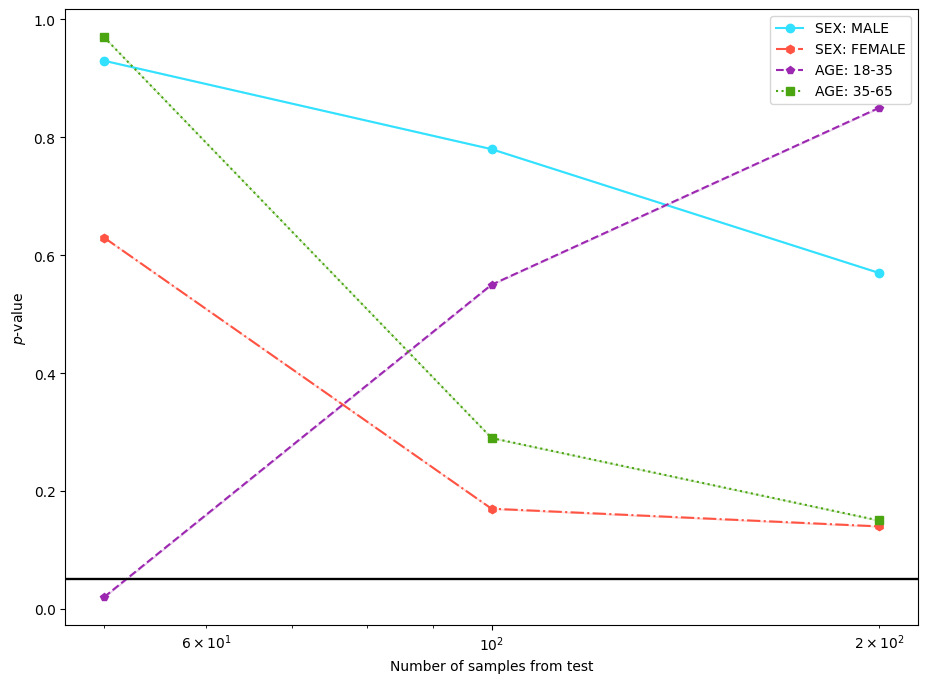

In [5]:
model = DenseNet(weights="densenet121-res224-all")
source_slice = None
target_slices = {
    "SEX: MALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "M"}}]),
    "SEX: FEMALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "F"}}]),
    "AGE: 18-35": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 18, "max_value": 35}}]
    ),
    "AGE: 35-65": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 35, "max_value": 65}}]
    ),
}
results = {}

for name, target_slice in target_slices.items():
    source_slice = None
    shifter = ClinicalShiftApplicator(
        "custom", source=source_slice, target=target_slice
    )
    ds_source, ds_target = shifter.apply_shift(nih_ds, num_proc=6)

    ds_source = ds_source.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )
    ds_target = ds_target.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )

    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    results[name] = detector.detect_shift(ds_source, ds_target)
plot_drift_experiment(results)

## Example 5. Rolling window experiment with synthetic timestamps using biweekly window

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.21 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.87 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.76 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 49.44 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.44 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 57.75 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 57.18 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.77 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.85 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.43 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.03 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.35 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.92 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.57 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.22 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.72 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.58 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.71 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.43 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.32 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.91 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.52 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.96 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.90 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.01 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.89 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.53 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.62 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.57 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.96 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.06 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.99 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.13 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.11 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.02 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.07 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.99 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.21 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.65 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.90 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.75 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.79 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.98 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.79 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.02 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.78 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.75 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.89 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.01 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.02 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.17 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.06 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.06 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.32 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.17 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.04 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.15 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.42 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.53 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.71 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.65 examples/s]

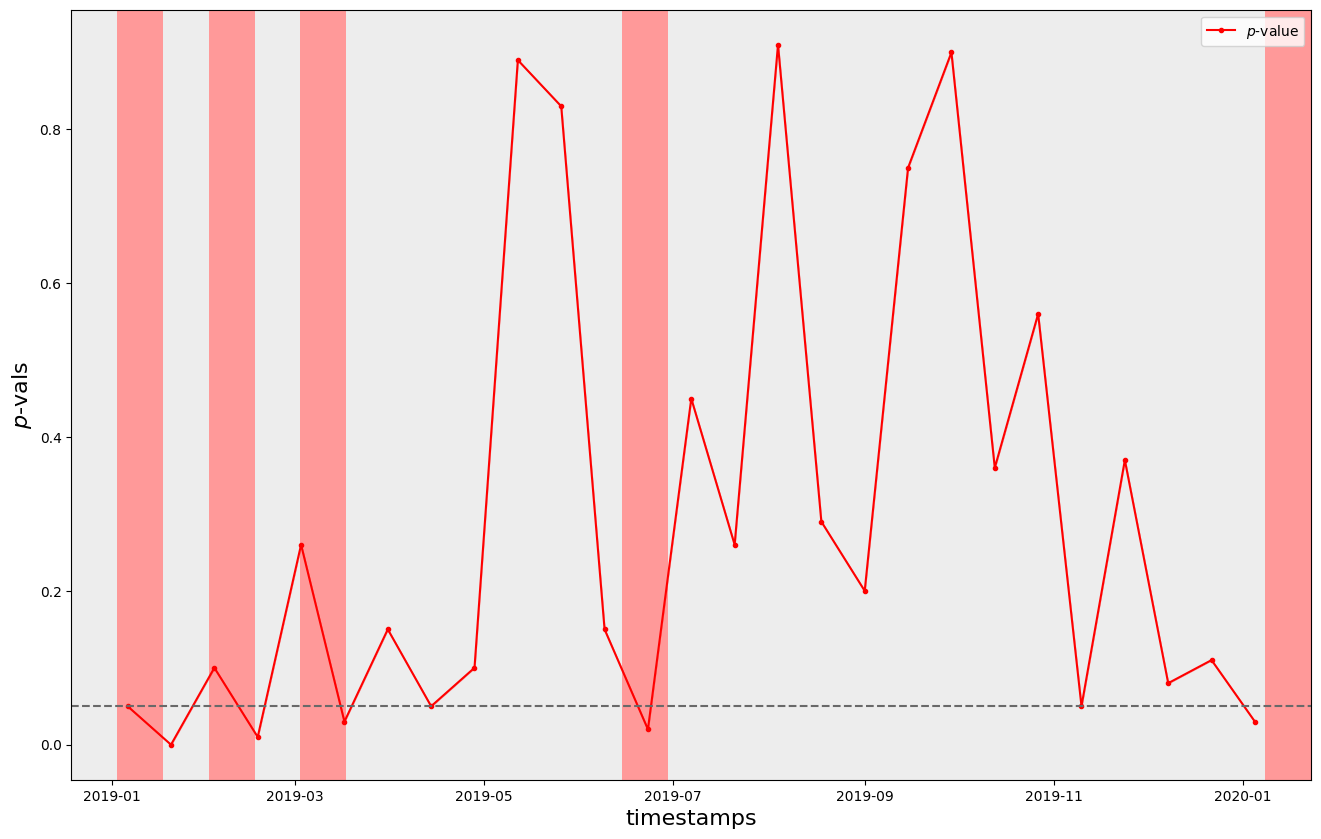

In [6]:
model = DenseNet(weights="densenet121-res224-all")
detector = Detector(
    "rolling_window_drift",
    reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
    tester=TSTester(tester_method="mmd"),
    source_sample_size=200,
    target_sample_size=50,
    timestamp_column="timestamp",
    window_size="2W",
)

results = detector.detect_shift(source_ds, target_ds)
plot_drift_timeseries(results)